# КМ-01 | Романецький Микита | PNN Cyberatack

### Імпортуємо бібліотеки

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

### Завантажимо датасет NSL-KDD

In [2]:
start_timer = time.time()
train_data = pd.read_csv('dataset\KDDTrain+.txt')
test_data = pd.read_csv('dataset\KDDTest+.txt')

### Даємо назви колонкам у датафреймі

In [3]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
            'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
            'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
            'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
            'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
            'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

train_data.columns = columns
test_data.columns = columns

### Перевіримо кількість записів які містять тип атаки 'rootkit' або 'normal'

In [4]:
def check_rootkit_normal():
    count_train_rootkit = (train_data['attack'] == 'rootkit').sum()
    count_test_rootkit = (test_data['attack'] == 'rootkit').sum()
    count_train_normal = (train_data['attack'] == 'normal').sum()
    count_test_normal = (test_data['attack'] == 'normal').sum()

    print(f'Кількість записів у датасеті \'train_data\': {train_data.shape[0]}')
    print(f'Кількість записів у датасеті \'test_data\' : {test_data.shape[0]}\n')

    print(f"Кількість входжень 'rootkit' у 'train_data': {count_train_rootkit}")
    print(f"Кількість входжень 'rootkit' у 'test_data':  {count_test_rootkit}")
    print(f"Кількість входжень 'normal'  у 'train_data': {count_train_normal}")
    print(f"Кількість входжень 'normal'  у 'test_data':  {count_test_normal}")

check_rootkit_normal()

Кількість записів у датасеті 'train_data': 125972
Кількість записів у датасеті 'test_data' : 22543

Кількість входжень 'rootkit' у 'train_data': 10
Кількість входжень 'rootkit' у 'test_data':  13
Кількість входжень 'normal'  у 'train_data': 67342
Кількість входжень 'normal'  у 'test_data':  9711


### Прибираємо з датасету всі записи, які не містять 'normal' або 'rootkit'

In [5]:
train_data = train_data[(train_data['attack'] == 'rootkit') | (train_data['attack'] == 'normal')]
test_data  = test_data[ (test_data['attack']  == 'rootkit') | (test_data['attack']  == 'normal')]

# train_data.dtypes
# test_data.dtypes

### Перекодуємо категорійні значення

In [6]:
# Використання one-hot encoding для категорійних змінних
filtered_train_data = pd.get_dummies(train_data, drop_first=True)
filtered_test_data  = pd.get_dummies(test_data,  drop_first=True)

### Перевіримо чи співпадають назви колонок та їх кількість
Це важливо оскільки ми передаємо ці значення в нейронну мережу

In [7]:
print(f'Колонок у \'filtered_train_data\': {filtered_train_data.shape[1]}')
print(f'Колонок у \'filtered_test_data\':  {filtered_test_data.shape[1]}')

# Отримання назв колонок для обох датафреймів
columns_train = set(filtered_train_data.columns)
columns_test = set(filtered_test_data.columns)

# Знаходження спільних назв колонок
common_columns = columns_train.intersection(columns_test)

# Виведення назв та кількості спільних колонок
print('Кількість спільних колонок:', len(common_columns))

# Знаходження унікальних колонок у кожному датафреймі
unique_columns_train = columns_train.difference(columns_test)
unique_columns_test = columns_test.difference(columns_train)

# Виведення назв унікальних колонок у кожному датафреймі
print(f'\nУнікальні колонки в filtered_train_data: \n{unique_columns_train}')
print(f'\nУнікальні колонки в filtered_test_data: \n{unique_columns_test}')
print(f'\nОтже, назви та кількість не співпадають')

Колонок у 'filtered_train_data': 76
Колонок у 'filtered_test_data':  70
Кількість спільних колонок: 67

Унікальні колонки в filtered_train_data: 
{'flag_REJ', 'service_shell', 'service_domain', 'service_imap4', 'service_urh_i', 'service_ssh', 'flag_SH', 'service_red_i', 'flag_S0'}

Унікальні колонки в filtered_test_data: 
{'service_link', 'service_remote_job', 'flag_RSTOS0'}

Отже, назви та кількість не співпадають


### Подивимось наскільки багато цих даних і чи можемо ми їх позбутися

In [8]:
a = (train_data['service'] == 'red_i').sum()
b = (train_data['service'] == 'ssh').sum()
c = (train_data['service'] == 'domain').sum()
d = (train_data['service'] == 'urh_i').sum()
e = (train_data['service'] == 'shell').sum()
f = (train_data['service'] == 'imap4').sum()

fl = (train_data['flag'] == 'REJ').sum()
fll = (train_data['flag'] == 'SH').sum()
flll = (train_data['flag'] == 'S0').sum()

ser1 = (test_data['service'] == 'link').sum()
ser2 = (test_data['service'] == 'remote_job').sum()
ser3 = (test_data['flag'] == 'RSTOS0').sum()

print(f"Кількість входжень 'red_i'  у 'train_data': {a}")
print(f"Кількість входжень 'ssh'    у 'train_data': {b}")
print(f"Кількість входжень 'domain' у 'train_data': {c}")
print(f"Кількість входжень 'urh_i'  у 'train_data': {d}")
print(f"Кількість входжень 'shell'  у 'train_data': {e}")
print(f"Кількість входжень 'imap4'  у 'train_data': {f}")

print(f"Кількість входжень 'REJ'    у 'train_data': {fl}")
print(f"Кількість входжень 'SH'     у 'train_data': {fll}")
print(f"Кількість входжень 'S0'     у 'train_data': {flll}")

print(f"\nКількість входжень 'link'   у 'test_data': {ser1}")
print(f"Кількість входжень 'job'    у 'test_data': {ser2}")
print(f"Кількість входжень 'RSTOS0' у 'test_data': {ser3}")

Кількість входжень 'red_i'  у 'train_data': 8
Кількість входжень 'ssh'    у 'train_data': 5
Кількість входжень 'domain' у 'train_data': 38
Кількість входжень 'urh_i'  у 'train_data': 10
Кількість входжень 'shell'  у 'train_data': 4
Кількість входжень 'imap4'  у 'train_data': 3
Кількість входжень 'REJ'    у 'train_data': 2693
Кількість входжень 'SH'     у 'train_data': 2
Кількість входжень 'S0'     у 'train_data': 354

Кількість входжень 'link'   у 'test_data': 1
Кількість входжень 'job'    у 'test_data': 1
Кількість входжень 'RSTOS0' у 'test_data': 1


### Видаляємо дані
Тренувальний датасет містить більше 67 тис. даних, а тестовий датасет 9 тис.  
Тому видалення такої кількості даних повинно сильно вплинути на результати досліджень 

In [9]:
# Видалення записів з умовами у train_data
train_data = train_data[(train_data['service'] != 'red_i') &
                        (train_data['service'] != 'ssh') &
                        (train_data['service'] != 'domain') &
                        (train_data['service'] != 'urh_i') &
                        (train_data['service'] != 'shell') &
                        (train_data['service'] != 'imap4') &
                        (train_data['flag'] != 'REJ') &
                        (train_data['flag'] != 'SH') &
                        (train_data['flag'] != 'S0')]

# Видалення записів з умовами у test_data
test_data = test_data[(test_data['service'] != 'link') &
                      (test_data['service'] != 'remote_job') &
                      (test_data['flag'] != 'RSTOS0')]

### Перевіримо чи зараз співпадають назви та кількість колонок

In [10]:
# Використання one-hot encoding для категорійних змінних
filtered_train_data = pd.get_dummies(train_data, drop_first=True)
filtered_test_data  = pd.get_dummies(test_data,  drop_first=True)

print(f'Колонок у \'filtered_train_data\': {filtered_train_data.shape[1]}')
print(f'Колонок у \'filtered_test_data\':  {filtered_test_data.shape[1]}')

# Отримання назв колонок для обох датафреймів
columns_train = set(filtered_train_data.columns)
columns_test = set(filtered_test_data.columns)

# Знаходження спільних назв колонок
common_columns = columns_train.intersection(columns_test)

# Виведення назв та кількості спільних колонок
print('Кількість спільних колонок:', len(common_columns))
print('\nОтже назви колонок у датафреймах повністю однакові')

Колонок у 'filtered_train_data': 67
Колонок у 'filtered_test_data':  67
Кількість спільних колонок: 67

Отже назви колонок у датафреймах повністю однакові


### Для коректної роботи НМ треба нормалізувати дані

In [11]:
scaler = MinMaxScaler()

new_columns = filtered_train_data.columns

filtered_train_data[new_columns] = scaler.fit_transform(filtered_train_data[new_columns])
filtered_test_data[new_columns] = scaler.transform(filtered_test_data[new_columns])

### Створюємо клас ймовірнісної нейронної мережі (PNN)

In [12]:
class PNN:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.mean_vectors = None
        self.sigma = None
        self.weights = None


    def train(self, X, y, sigma=1.0):
        self.mean_vectors = []
        self.sigma = sigma

        # Обчислюємо середні вектори для кожного класу
        for class_label in range(self.output_size):
            class_samples = X[y == class_label]
            mean_vector = np.mean(class_samples, axis=0)
            self.mean_vectors.append(mean_vector)

        self.mean_vectors = np.array(self.mean_vectors)

        # Обчислюємо ваги для кожного класу
        self.weights = np.ones(self.output_size) / self.output_size


    def predict(self, X):
        predictions = []

        for sample in X:
            probabilities = []

            # Розраховуємо ймовірності для кожного класу
            for class_label in range(self.output_size):
                mean_vector = self.mean_vectors[class_label]
                sample = sample.astype(float)
                activation = np.exp(-0.5 * np.sum((sample - mean_vector) ** 2) / (self.sigma ** 2))
                probability = activation * self.weights[class_label]
                probabilities.append(probability)

            # Визначаємо клас з найвищою ймовірністю
            predicted_class = np.argmax(probabilities)
            predictions.append(predicted_class)

        return np.array(predictions)

### Розділимо датафрейми `filtered_train_data` та `filtered_test_data` на X_train, X_test, y_train, y_test

In [13]:
X_train = filtered_train_data.drop(columns=['attack_rootkit'])
y_train = filtered_train_data['attack_rootkit']

X_test = filtered_test_data.drop(columns=['attack_rootkit'])
y_test = filtered_test_data['attack_rootkit']

### Ініціалізуємо модель PNN

In [14]:
input_size = train_data.shape[1]
output_size = 2  # розмірність вихідного шару (два класи: rootkit та normal)

pnn = PNN(input_size, output_size)

### Навчання PNN

In [15]:
pnn.train(X_train, y_train, sigma=0.077)

### Використання PNN

In [16]:
predictions = pnn.predict(X_test.values)

### Знайдемо метрики, щоб зрозуміти наскільки хороших результатів було досягнуто

In [17]:
y_true = y_test
accuracy = accuracy_score(y_true, predictions)
precision = precision_score(y_true, predictions)
recall = recall_score(y_true, predictions)
f1 = f1_score(y_true, predictions)

print(f"Accuracy (Точність) : {round(accuracy * 100, 5)} %")
print(f"Precision (Точність): {round(precision * 100, 5)} %")
print(f"Recall (Повнота)    : {round(recall * 100, 5)} %")
print(f"F1 Score (F-міра)   : {round(f1 * 100, 5)} %")

Accuracy (Точність) : 93.22086 %
Precision (Точність): 1.93452 %
Recall (Повнота)    : 100.0 %
F1 Score (F-міра)   : 3.79562 %


### Побудуємо гістограму з результатами дослідження

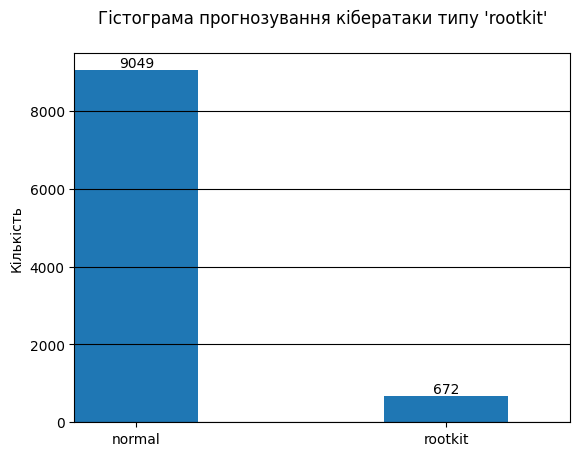

In [18]:
cord = [0.1, 0.6]
for i, value in zip(cord, plt.hist(predictions, bins=2, width=0.2)[0]):
    plt.text(i, value + 0.1, str(int(value)), ha='center', va='bottom')
plt.title('Гістограма прогнозування кібератаки типу \'rootkit\'\n')
plt.ylabel('Кількість')
plt.xticks([0.1, 0.6], ['normal', 'rootkit'])
plt.xlim(0, 0.8)
plt.grid(axis='y',c='black')
plt.show()


### Побудуємо теплову карту з результатами дослідження

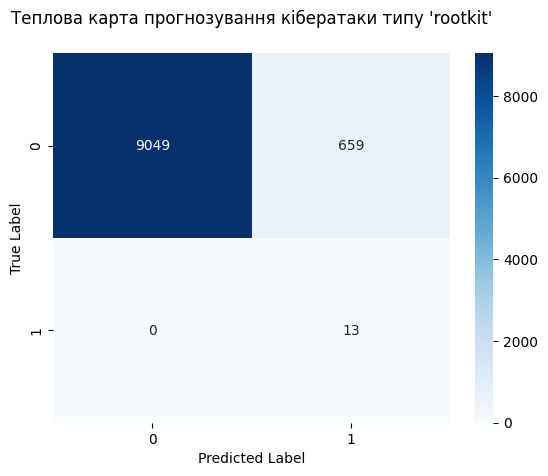

In [19]:
cm = confusion_matrix(y_true, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Теплова карта прогнозування кібератаки типу \'rootkit\'\n')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Побудуємо ROC-криву з результатами дослідження

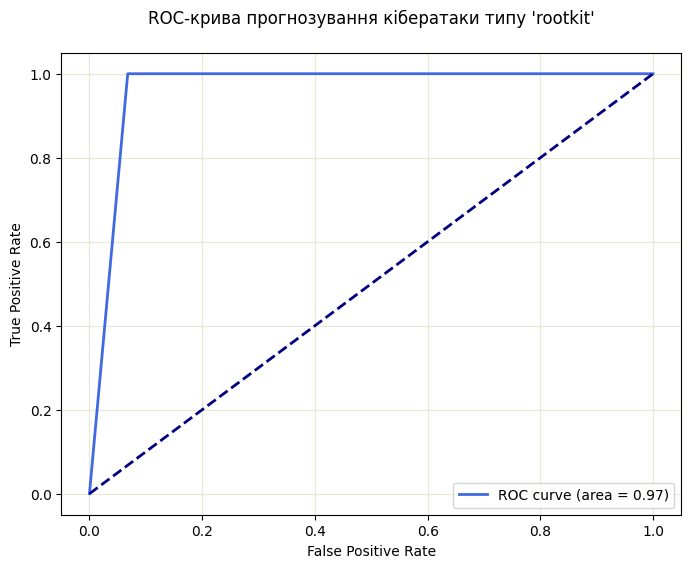

In [20]:
fpr, tpr, _ = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='royalblue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-крива прогнозування кібератаки типу \'rootkit\'\n')
plt.legend(loc='lower right')
plt.grid(c='#E7E8D2')
plt.show()

### Характеристика системи та часові витрати на роботу програми

In [21]:
print(f'Час роботи програми: {round(time.time() - start_timer, 1)} секунд\n')
print(f'Процесор:   AMD Ryzen 5 3550H with Radeon Vega')
print(f'ОЗП:        8.00 ГБ')
print(f'ОС:         Windows 10 Pro')

Час роботи програми: 6.3 секунд

Процесор:   AMD Ryzen 5 3550H with Radeon Vega
ОЗП:        8.00 ГБ
ОС:         Windows 10 Pro
